In [2]:
import msiwarp as mx

from msiwarp.util.read_sbd import read_sbd_meta, read_spectrum_fs
from msiwarp.util.warp import to_mx_peaks, to_mz, to_height, peak_density_mz
from msiwarp.util.warp import spectra_to_triplet, plot_range, get_mx_spectrum
from msiwarp.util.warp import generate_mean_spectrum

import matplotlib.pyplot as plt
import numpy as np

In [3]:
i_r = 200

# scaling to test impact of sigma on alignment performance
sigma_1 = 3.0e-7
epsilon = 0.5

print("using spectrum {} as reference, sigma: {} ppm, and epsilon: {:0.2f} ppm".format(i_r, sigma_1 * 1e6, 2 * epsilon * sigma_1 * 1e6))

fdir = 'datasets/orbitrap-liver/'

fpath_sbd = fdir + '5mixes_onratliver_50micron-centroided.sbd'
fpath_triplets_raw = fdir + 'triplets_raw.dat'
fpath_triplets_warped = fdir + 'triplets_warped.dat'
fpath_dispersion_csv = fdir + 'results/dispersion_100.csv'
fpath_scatter = fdir + 'results/scatter'

# experiment settings
instrument_type = 'orbitrap'
mz_begin = 150
mz_end = 1000

meta = read_sbd_meta(fpath_sbd)
spectra = [get_mx_spectrum(fpath_sbd, meta, i, sigma_1, instrument_type) for i in range(len(meta))]
tic = np.array([m[2] for m in meta])

using spectrum 200 as reference, sigma: 0.3 ppm, and epsilon: 1.53 ppm


In [11]:
xi = np.linspace(mz_begin, mz_end, 1000)
(yi, xp, yp) = peak_density_mz(spectra, xi, bandwidth=15, stride=100)

# we're using the same warping nodes for all spectra here
node_mzs = (xp[:-1] + xp[1:]) / 2
node_mzs = np.array([mz_begin, *node_mzs, mz_end])

# setup warping parameters 
n_steps = 33 # the slack of a warping node is +- (n_steps * s * sigma @ the node's m/z)
s = 2 * epsilon / n_steps 

node_deltas = np.array([s * sigma_1 * mz ** (3/2)  for mz in node_mzs])
nodes = mx.initialize_nodes(node_mzs, node_sigmas, n_steps)

In [13]:
s_r = get_mx_spectrum(fpath_sbd, meta, i_r, sigma_1, instrument_type)

print("warping spectra...")

import time
t0 = time.time()
optimal_moves = mx.find_optimal_spectra_warpings(spectra, s_r, nodes, epsilon)
t1 = time.time()
print("found optimal warpings in {:0.2f}s".format(t1 - t0))

t2 = time.time()
warped_spectra = [mx.warp_peaks(s_i, nodes, o_i) for (s_i, o_i) in zip(spectra, optimal_moves)]
t3 = time.time()
print("warped spectra in {:0.2f}s".format(t3 - t2))

warping spectra...
found optimal warpings in 247.16s
warped spectra in 23.98s


In [22]:
n_points = 2000000

s_m = generate_mean_spectrum(spectra, n_points, sigma_1,
                             mz_begin, mz_end, tic, instrument_type)

s_m_100 = mx.peaks_top_n(s_m, 100)
mz_ref = np.sort(to_mz(s_m_100))

generating mean spectrum with 1334052 sampling points...
generated mean spectrum


made scatter plot output directory


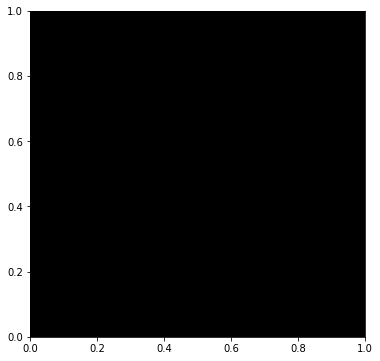

In [35]:
mass_tolerance = 5 # ppm

import os

if not os.path.exists(fpath_scatter):    
    os.makedirs(fpath_scatter)
    print("made scatter plot output directory")
else:
    print("using existing scatter plot output directory")
    
fig, ax = plt.subplots(figsize=(6,6))
for i, mz_i in enumerate(mz_ref):
    d = mass_tolerance * mz_i / 1e6 # -+ mass_tolerance around reference mass 
    mz0 = mz_i - d
    mz1 = mz_i + d    
    
    plot_range(fpath_triplets_raw, mz0, mz1, ax, 'tab:cyan', 5, in_ppm=True)
    plot_range(fpath_triplets_warped, mz0, mz1, ax, 'tab:orange', 5, in_ppm=True)
    
    ax.set_facecolor((0.0, 0.0, 0.0))
    ax.set_title('m/z {:0.3f}'.format(mz_i))
    ax.set_xticks([-mass_tolerance, 0, mass_tolerance])
#     ax.set_xlim([mz0, mz1])
    
    fig.savefig(fpath_scatter + '/mz_{}.png'.format(int(mz_i)), dpi=200)
    ax.cla()

In [28]:
from msiwarp.util.warp import dispersion_triplets
import pandas as pd

dispersion_raw = np.zeros(len(mz_ref))
dispersion_warped = np.zeros(len(mz_ref))
    
for i, mz_i in enumerate(mz_ref):
    d = mass_tolerance * mz_i / 1e6 # -+ 350 ppm around reference mass
    mz0 = mz_i - d
    mz1 = mz_i + d
    
    ts_raw = mx.get_triplets_range(fpath_triplets_raw, mz0, mz1)
    ts_warped = mx.get_triplets_range(fpath_triplets_warped, mz0, mz1)
    
    q = 0.0 # remove background signal
    if len(ts_raw) > 0:
        dispersion_raw[i] = dispersion_triplets(ts_raw,  q)
    if len(ts_warped) > 0:  
        dispersion_warped[i] = dispersion_triplets(ts_warped, q)


d = {'mz': mz_ref,
     'dispersion raw [ppm]': dispersion_raw,
     'dispersion warped [ppm]': dispersion_warped}

df = pd.DataFrame(d)
df.round(4).to_csv(fpath_dispersion_csv, index=False)
b
print('median mass dispersion raw: {:0.4f}'.format(np.median(dispersion_raw)))
print('median mass dispersion warped: {:0.4f}'.format(np.median(dispersion_warped)))

median mass dispersion raw: 0.5924
median mass dispersion warped: 0.1821
